In [17]:
using DataFrames, PyPlot, ScikitLearn, LowRankModels

In [18]:
include("proxgrad.jl")

proxgrad_const (generic function with 1 method)

In [65]:
birth = readtable("birthSample.txt", separator = '\t')

,MaritalStatus,PrenatalCare,Male,Weight
1,0,1,0,3326
2,1,0,0,1340
3,0,0,0,3033
4,1,1,1,3884
5,0,0,0,3108
6,1,1,1,3912
7,1,1,1,2546
8,1,1,1,4545
9,0,1,0,3402
10,1,1,1,3884


In [66]:
n = nrow(birth)

9322

In [67]:
std(X,1)

1×4 Array{Float64,2}:
 0.0  0.488987  0.499732  0.435636

In [68]:
mean(X)
std(X)

0.4505721681169909

In [69]:
y = convert(Array, birth[:Weight])
X = convert(Array, birth[:, [:MaritalStatus, :Male, :PrenatalCare]])

# standardize data
ys = y - mean(y)
ys = ys ./ std(y)
Xs = X .- mean(X,1)
Xs = Xs * diagm(vec(std(Xs,1)).^(-1))

X = [ones(n) X]
Xs = [ones(n) Xs]

9322×4 Array{Float64,2}:
 1.0  -1.2362    -1.03488   0.584338
 1.0   0.808847  -1.03488  -1.71115 
 1.0  -1.2362    -1.03488  -1.71115 
 1.0   0.808847   0.96619   0.584338
 1.0  -1.2362    -1.03488  -1.71115 
 1.0   0.808847   0.96619   0.584338
 1.0   0.808847   0.96619   0.584338
 1.0   0.808847   0.96619   0.584338
 1.0  -1.2362    -1.03488   0.584338
 1.0   0.808847   0.96619   0.584338
 1.0  -1.2362     0.96619   0.584338
 1.0  -1.2362    -1.03488   0.584338
 1.0  -1.2362     0.96619  -1.71115 
 ⋮                                  
 1.0   0.808847   0.96619   0.584338
 1.0   0.808847   0.96619   0.584338
 1.0  -1.2362     0.96619   0.584338
 1.0  -1.2362     0.96619   0.584338
 1.0   0.808847  -1.03488   0.584338
 1.0  -1.2362    -1.03488  -1.71115 
 1.0   0.808847  -1.03488   0.584338
 1.0   0.808847  -1.03488   0.584338
 1.0  -1.2362     0.96619   0.584338
 1.0  -1.2362    -1.03488   0.584338
 1.0   0.808847   0.96619   0.584338
 1.0  -1.2362     0.96619   0.584338

# a) Fit a linear regression model

In [70]:
@sk_import linear_model: LinearRegression
lr = LinearRegression(fit_intercept = 0)
ScikitLearn.fit!(lr, X, y)
w_linear = lr[:coef_]

4-element Array{Float64,1}:
 3138.93  
  101.362 
  124.357 
   73.0585

In [71]:
w_linear = proxgrad(QuadLoss(), ZeroReg(), X, y, maxiters=1000, ch = ConvergenceHistory(""))

4-element Array{Float64,1}:
 3138.93  
  101.362 
  124.357 
   73.0587

We find that all the coefficients have a positive value. Gender seems to be the most important. Prenatal care is the least important.

# b) Quantile Regression

In [74]:
using QuantileRegression

In [101]:
ResultQR = qreg(Weight~MaritalStatus+Male+PrenatalCare, birth, .05)
w_5 = coeftable(ResultQR)
w_5

               Estimate Std.Error t value
(Intercept)      2160.0   39.3054 54.9543
MaritalStatus     225.0   32.6229 6.89699
Male               50.0   31.9034 1.56723
PrenatalCare      130.0   36.6483 3.54723


In [102]:
ResultQR = qreg(Weight~MaritalStatus+Male+PrenatalCare, birth, .95)
w_95 = coeftable(ResultQR)
w_95

               Estimate Std.Error t value
(Intercept)      3948.0   24.9595 158.176
MaritalStatus      79.0   21.6937 3.64161
Male              193.0   20.8951 9.23659
PrenatalCare       55.0    24.334 2.26021


The effect of prenatal care is much larger for babies in the bottom 5th quantile. This indicates that the 5th quantile is more affected by marital status and prenatal care than other percentiles.

c)

In [119]:
w = w_5.cols[1]
for q in linspace(0.1, 0.95, 18)
    result = qreg(Weight~MaritalStatus+Male+PrenatalCare, birth, q)
    w = hcat(w, coeftable(result).cols[1])
end

In [120]:
w

4×19 Array{Float64,2}:
 2160.0  2509.0  2661.0  2768.0  2855.0  …  3568.0  3638.5  3771.0  3948.0
  225.0   133.0   110.0   102.0   100.0       85.0    75.5    87.0    79.0
   50.0    85.0    99.0    98.0    95.0      146.0   151.5   158.0   193.0
  130.0    80.0    75.0    68.0    75.0       57.0    75.5    54.0    55.0

d)

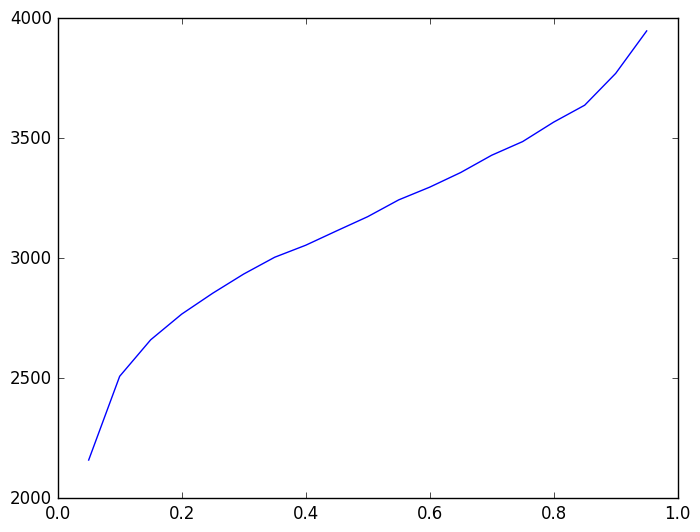

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x319d97350>

In [121]:
#Intercept
plot(linspace(0.05, 0.95, 19), w[1,:])

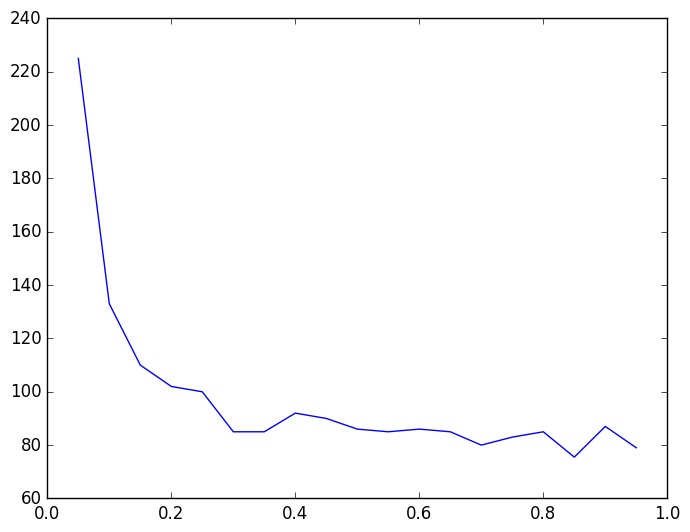

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x319b10a50>

In [122]:
#Marital Status
plot(linspace(0.05, 0.95, 19), w[2,:])

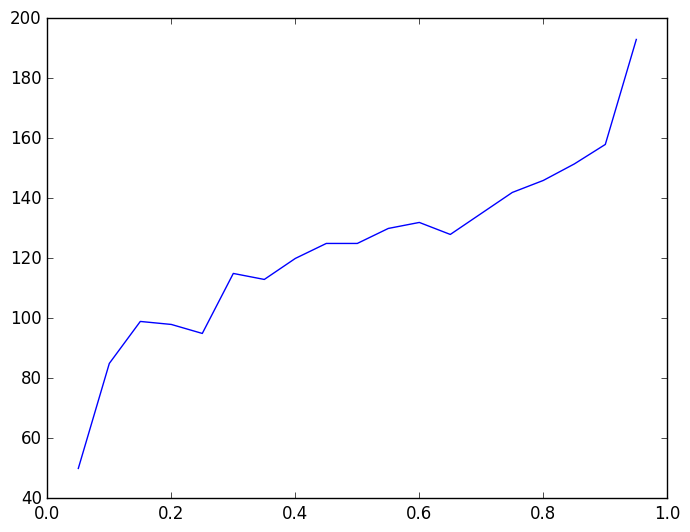

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31996ad90>

In [123]:
#Male
plot(linspace(0.05, 0.95, 19), w[3,:])

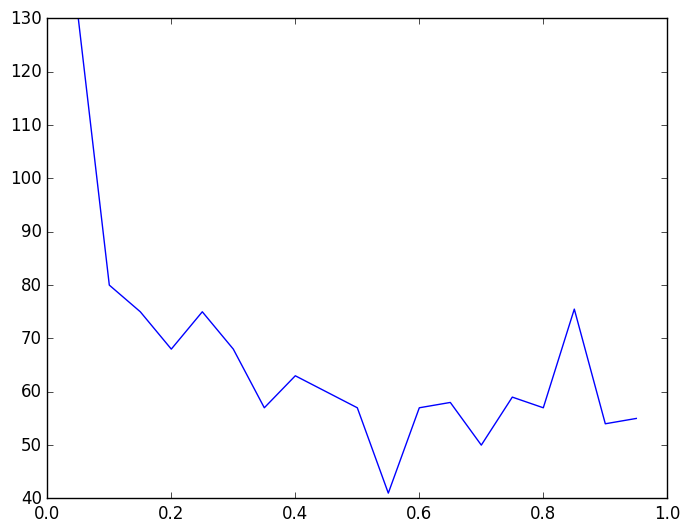

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3192ae210>

In [124]:
#Prenatal care
plot(linspace(0.05, 0.95, 19), w[4,:])

It's clear that prenatal care and marital status are the biggest factors for babies in the lower percentiles. Sex, however, is a bigger factor for babies in the higher percentiles.

d)

The intercept can be interpreted as the conditional quantile estimated birth weight of a female baby born to an unmarried mother who did not have prenatal care in the first trimester.

e) The coefficient plots tell us that prenatal care is very important for babies with low birth weight.